In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
from numpy import linalg

import sys
sys.path.append('..')
from module.construct_q import Q_mtx_fast
from module._rc_operations import reservoir

from scipy.stats import unitary_group
from scipy.stats import ortho_group
from module.edge_measure import PointDistributionAnalyzer


In [2]:
import pandas as pd

In [3]:
from module.fourier_motif import fourier_motif_plots, fft_m, plot_complex, RC_relative_area
from module._rc_operations import cycle, reservoir

from module.util import spec_radius

In [4]:
motif_w_rel_threshold = 0.01

In [5]:
spec_rad_inputs = [0.9812798473475446, 0.999, 1]


/var/folders/bc/1bx718cj76b7_sg6yjyzrnkc0000gn/T/ipykernel_5070/1445106086.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


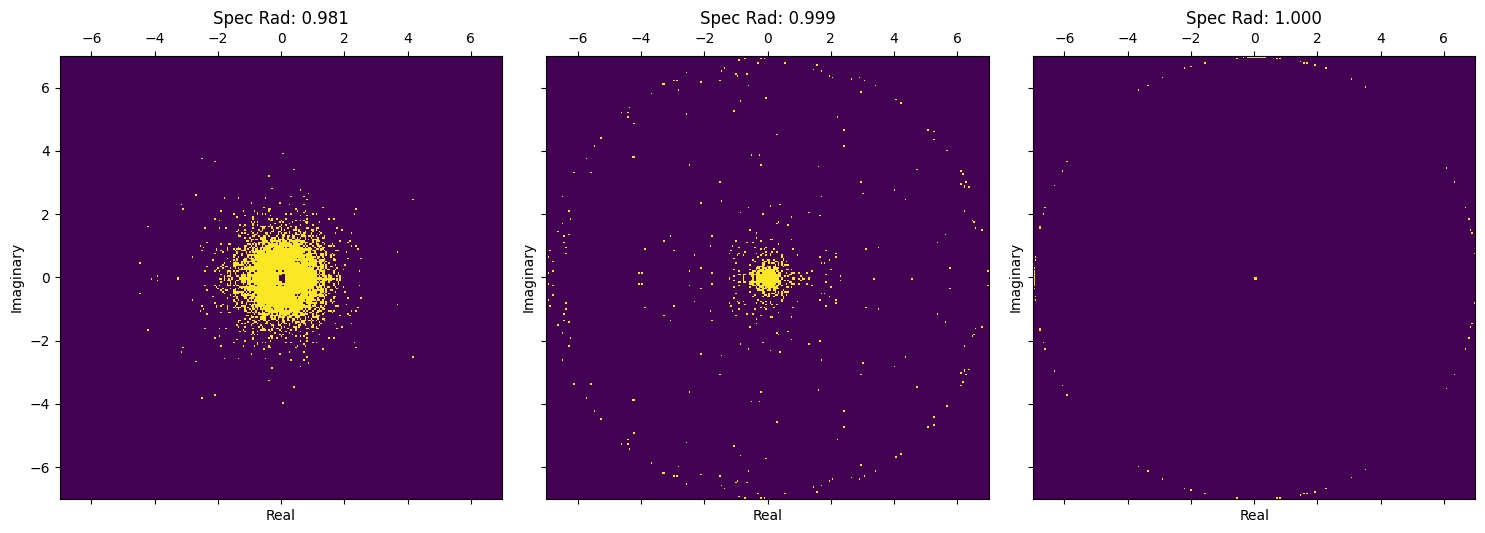

In [6]:


n_res = 97
n_in = 1; rin_input = 1; 


interval_len = n_res 
parzen_bandwidth = 0.5

hist_bin = 100

gap = 0.05
lower_hist = -7
upper_hist = -1*lower_hist



fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True, sharex=True, sharey=True)

all_histograms = []  # To store all histograms for a combined color bar

for i, spec_rad_input in enumerate(spec_rad_inputs):
    # Reservoir and Input Weight Matrices
    W, V = reservoir(n_res, n_in, rin=rin_input, spectral_radius=spec_rad_input, win_rand=0)

    Win = V

    #print('Computing Q...')
    Qp = Q_mtx_fast(W, V, interval_len)
    #print('Computing motifs...')
    motif, motif_weight, _ = np.linalg.svd(Qp, full_matrices=True)
    motif_weighted_ = motif@np.diag(motif_weight)
    # motif_w = motif @ np.diag(motif_weight)
    ind = np.where(motif_weight >= max(motif_weight) * motif_w_rel_threshold)
    motif = motif[:, ind[0]]
    fourier_coeff = fft_m(motif)

    fourier_coeff_study = fft(motif, axis=0)    

    x,y= plot_complex(fourier_coeff, axs[i])
    xedges = np.arange(lower_hist,upper_hist,gap)
    yedges = xedges
    extenti = (lower_hist,upper_hist)
    extentj = (lower_hist,upper_hist)
    

    H, xedges, yedges = np.histogram2d(y,x, bins=(xedges, yedges))
    # H = H.T  # Let each row list bins with common y range.
    
    
    
    axs[i].matshow(H!=0, extent=np.ravel([extentj, extenti]))
    
    axs[i].set_title(f"Spec Rad: {spec_rad_input:.3f}")
    axs[i].set_xlabel("Real")
    axs[i].set_ylabel("Imaginary")


plt.tight_layout()



In [7]:
# # The other way of writing the above.
# hist, *edges = np.histogram2d(y,x, bins=xedges.shape[0], range=(extenti, extentj))
# plt.matshow(hist!=0, extent=np.ravel([extentj, extenti]))

#spec_rad_list = np.arange(0.5,1.05,0.05)
spec_rad_list = np.concatenate((np.linspace(0.5,0.95,10), np.logspace(np.log10(0.95), np.log10(0.9999999), 20), np.array([1])))
count_rand = np.zeros_like(spec_rad_list)
#count_scr = count_rand
_, V = reservoir(n_res,1, spectral_radius = 1, rin = 1)


In [8]:
# Test new motif-fft
C1 = cycle(n_res, spectral_radius = 1)
    

QC1 = Q_mtx_fast(C1, V, interval_len)
# print('Computing motifs...')
motif_C, motif_weight, _ = np.linalg.svd(QC1, full_matrices=True)



In [9]:
C1.shape

(97, 97)

In [10]:
count_rand = np.zeros_like(spec_rad_list)
count_scr = np.zeros_like(spec_rad_list)
count_unitary = np.zeros_like(spec_rad_list)
count_orthogonal = np.zeros_like(spec_rad_list)

measure_rand = []
measure_scr = []
measure_unitary = []
measure_orthogonal = []

count_rand_entropy = np.zeros_like(spec_rad_list)
count_scr_entropy = np.zeros_like(spec_rad_list)
count_unitary_entropy = np.zeros_like(spec_rad_list)
count_orthogonal_entropy = np.zeros_like(spec_rad_list)

count_rand_variance = np.zeros_like(spec_rad_list)
count_scr_variance = np.zeros_like(spec_rad_list)
count_unitary_variance = np.zeros_like(spec_rad_list)
count_orthogonal_variance = np.zeros_like(spec_rad_list)

count_rand_pw = np.zeros_like(spec_rad_list)
count_scr_pw = np.zeros_like(spec_rad_list)
count_unitary_pw = np.zeros_like(spec_rad_list)
count_orthogonal_pw = np.zeros_like(spec_rad_list)


In [11]:
hist_bin = 10

/Users/rsfong/Documents/GitHub/motif_Fourier/module/construct_q.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  phi[:, i] = phi_col.squeeze()
/Users/rsfong/anaconda3/envs/uni_scr/lib/python3.11/site-packages/scipy/stats/_entropy.py:154: RuntimeWarning: invalid value encountered in divide
  qk = 1.0*qk / xp.sum(qk, **sum_kwargs)  # type: ignore[operator, call-overload]


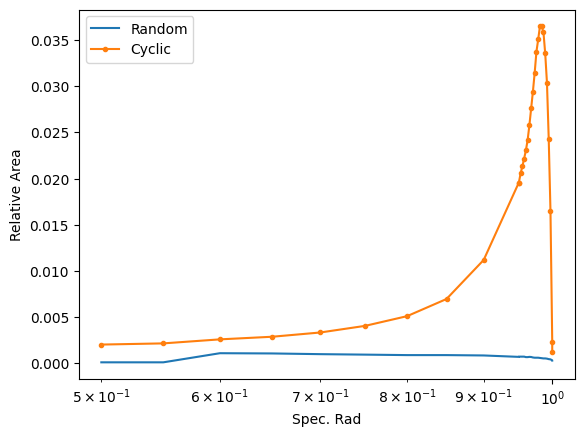

In [12]:
for i in range(len(spec_rad_list)):
#     print(spec_rad_list[i])
    spectral_radius = spec_rad_list[i]
    
    # Cyclic
    C = cycle(n_res, spectral_radius = spectral_radius)
    
    count_scr[i], result_scr = RC_relative_area(C, V, basis_real= motif_C.T, basis_imag=np.zeros_like(motif_C), 
                                    interval_len = n_res, hist_bin = hist_bin, extra_measure = True, parzen_bandwidth = parzen_bandwidth)
    
    measure_scr.append(result_scr)
    
    count_scr_entropy[i] = result_scr['entropy']
    count_scr_variance[i] = result_scr['variance']
    count_scr_pw[i] = result_scr['parzen']

    
    # Unitary
    U = unitary_group.rvs(n_res)
    
    U *= spectral_radius/ spec_radius(U)
    
    count_unitary[i],result_unitary = RC_relative_area(U, V, basis_real= motif_C.T, basis_imag=np.zeros_like(motif_C), 
                                        interval_len = n_res, hist_bin = hist_bin, extra_measure = True, parzen_bandwidth = parzen_bandwidth)
    
    measure_unitary.append(result_unitary)
    
    count_unitary_entropy[i] = result_unitary['entropy']
    count_unitary_variance[i] = result_unitary['variance']
    count_unitary_pw[i] = result_unitary['parzen']
    
    UO = ortho_group.rvs(n_res)
    
    UO *= spectral_radius / spec_radius(UO)
    
    count_orthogonal[i], result_orthogonal = RC_relative_area(UO, V, basis_real= motif_C.T, basis_imag=np.zeros_like(motif_C), 
                                        interval_len = n_res, hist_bin = hist_bin, extra_measure = True, parzen_bandwidth = parzen_bandwidth)
    
    measure_orthogonal.append(result_orthogonal)
    
    count_orthogonal_entropy[i] = result_orthogonal['entropy']
    count_orthogonal_variance[i] = result_orthogonal['variance']
    count_orthogonal_pw[i] = result_orthogonal['parzen']

    
    # Random
    W = np.random.rand(n_res, n_res)
    radius = spec_radius(W)
    W *= spectral_radius / radius
    
    count_rand[i], result_random = RC_relative_area(W, V, basis_real= motif_C.T, basis_imag=np.zeros_like(motif_C), 
                                                    interval_len = n_res, hist_bin = hist_bin, extra_measure = True, parzen_bandwidth = parzen_bandwidth)
    
    measure_rand.append(result_random)
    
    count_rand_entropy[i] = result_random['entropy']
    count_rand_variance[i] = result_random['variance']
    count_rand_pw[i] = result_random['parzen']

plt.plot(spec_rad_list, count_rand, label = 'Random')
plt.plot(spec_rad_list, count_scr, '.-', label = 'Cyclic')
# plt.plot(spec_rad_list, count_unitary, '*-', label = 'Unitary')
# plt.plot(spec_rad_list, count_orthogonal, '--', label = 'Orthogonal')


plt.xlabel('Spec. Rad')
plt.ylabel('Relative Area')
plt.xscale('log')
plt.legend()

plt.savefig('results/relative_area.png')
plt.show()

# spec_rad_list = np.arange(0.5, 1.1, 0.1)
# count = np.zeros_like(spec_rad_list)
# for i in range(len(spec_rad_list)):
#     print(spec_rad_list[i])
#     spectral_radius = spec_rad_list[i]
    
    
#     W = cycle(n_res, spectral_radius = spectral_radius)
#     count[i] = RC_relative_area(W,V, do_plot=True)